### Multi-label classificatio

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score

In [3]:
# no need this
# torch.cuda.set_device(0)
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

Tesla K80


In [4]:
PATH = 'data/'
arch=resnext50
bs=28

In [5]:
def get_data(size):
    tfms = tfms_from_model(arch, size, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)

In [6]:
size = 64
data = get_data(size)
data = data.resize(int(size*1.3), 'tmp') 
# for speed up training in different size by pre generate new size image

datasets: [<fastai.dataset.FilesIndexArrayDataset object at 0x7f087bb4ef98>, <fastai.dataset.FilesIndexArrayDataset object at 0x7f087bae2048>, <fastai.dataset.FilesIndexArrayDataset object at 0x7f087bae2160>, <fastai.dataset.FilesIndexArrayDataset object at 0x7f087bae2208>, None, None]


### 1. Find learning rate

 81%|████████  | 323/401 [00:15<00:03, 20.51it/s, loss=8]   

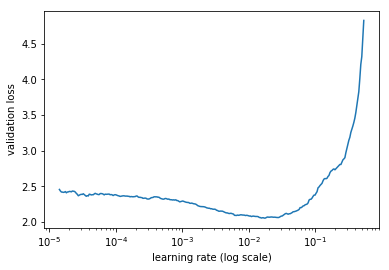

In [7]:
learn = ConvLearner.pretrained(arch, data)
learn.lr_find()
learn.sched.plot()

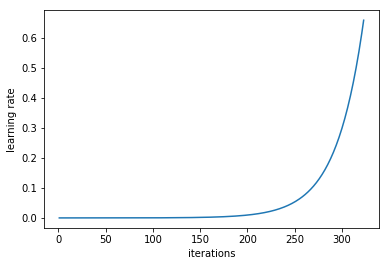

In [8]:
learn.sched.plot_lr()

### 2. Train Last Fully Connected Layer

In [9]:
lr = 0.03
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.682357   1.528232   0.41227   
    1      1.615648   1.51566    0.415542                   
    2      1.533572   1.472135   0.434151                   
    3      1.576176   1.475705   0.437219                   
    4      1.53466    1.455669   0.437628                   
    5      1.49334    1.434424   0.447648                   
 51%|█████     | 205/401 [00:09<00:09, 21.36it/s, loss=1.47]

KeyboardInterrupt: 

### 3. Unfreeze to train all layers

In [ ]:
learn.unfreeze()
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{size}')
learn.sched.plot_loss()

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
accuracy_np(preds,y)

### 4. Change size to size=128 and do it again

In [ ]:
size=128
learn.set_data(get_data(size))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{size}')

### 5. Change size to size=256 and do it again

In [ ]:
size=256
learn.set_data(get_data(size))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{size}')

### Last Accuracy

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
accuracy_np(preds,y)

### Load Model

In [ ]:
PATH = 'data/'
arch=resnext50
size = 256
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, size))
learn = ConvLearner.pretrained(arch, data)
learn.load('../../data/tmp/83/models/256')

multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
accuracy_np(preds,y)

In [ ]:
def predict(image_path):
    trn_tfms, val_tfms = tfms_from_model(arch, size)
    img = open_image(image_path)
    im = val_tfms(img)
    return learn.predict_array(im[None])
# np.argmax(predict('data/valid/convertible/Aston Martin V8 Vantage Convertible 201200239.jpg'))
# np.argmax(predict('data/valid/coupe/Acura Integra Type R 200102742.jpg'))
np.argmax(predict('data/valid/hatchback/Acura ZDX Hatchback 201200036.jpg'))


In [ ]:
data.val_ds